# Cancelamento de Clientes - Telco (dataset criado pela IBM para demonstração da ferramenta IBM Cognos Analytics)

### Contém informações sobre uma empresa fictícia de telecomunicações que forneceu serviços de telefonia residencial e internet para 7043 clientes na Califórnia no 3º trimestre.

### Etapa final do modelo - Realizado por Sabrina Otoni da Silva - 2024/01

### Objetivo: Criar o script para utilização do modelo e entendimento das predições finais. 

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score
# from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight

from xgboost import XGBClassifier

import pickle

import sys
import os

import time

automations_dir = os.path.join(os.getcwd(), '../automations')

if automations_dir not in sys.path:
    sys.path.append(automations_dir)

from data_processing import LogTransformer, KMeansCluster, DropColumns, CategoricalEncoder

import prediction_model

import warnings

In [2]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [3]:
datapath = Path('../data')
preprocessing_path = Path('../preprocessing')
model_path = Path('../model')
csv_path = Path(f'{datapath}/d02_intermediate')

In [4]:
X_train = pd.read_csv(f'{csv_path}/X_train.csv')
y_train = pd.read_csv(f'{csv_path}/y_train.csv').squeeze()

X_test = pd.read_csv(f'{csv_path}/X_test.csv')
y_test = pd.read_csv(f'{csv_path}/y_test.csv').squeeze()

In [5]:
weights_classes = compute_sample_weight(class_weight='balanced', y=y_train)

In [6]:
with open(f'{model_path}/weights_classes.txt', 'w') as file:
    file.write(str(weights_classes))

In [7]:
preprocessing = Pipeline([
    ('kmeans_cluster', KMeansCluster(model_path='../preprocessing/kmeans_model.pkl', columns_cluster=['Latitude', 'Longitude'])),
    ('import_drop', DropColumns(drop_columns=["City", "Latitude", "Longitude", "ID"])),
    ('categorical_encoder', CategoricalEncoder(encoder_type='label', specified_columns=["Gender", "Senior Citizen", "Partner", "Dependents",
                                                                                                    "Phone Service", "Multiple Lines", "Internet Service",
                                                                                                    "Online Security", "Online Backup", "Device Protection",
                                                                                                    "Tech Support", "Streaming TV", "Streaming Movies", 
                                                                                                    "Contract", "Paperless Billing", "Payment Method",
                                                                                                    "Cluster"])),
    ('log_transformation', LogTransformer(model_path='../preprocessing/log_transformer_model.pkl', columns=['Total Charges'])),
    # ('scaler', StandardScaler())
])

In [8]:
xgb_model = XGBClassifier(objective='binary:logistic', booster='gbtree', learning_rate=0.1, gamma=0.01, max_depth=3, subsample=0.8, colsample_bytree=0.6, sample_weight=weights_classes)

In [9]:
preprocessing.fit(X_train)
X_train = preprocessing.transform(X_train)

In [10]:
start_train_time = time.time()
xgb_model.fit(X_train, y_train)
train_time = time.time() - start_train_time

In [11]:
with open(f'{preprocessing_path}/preprocessing.pkl', 'wb') as file:
    pickle.dump(preprocessing, file)

with open(f'{model_path}/xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

In [12]:
start_predict_time = time.time()
predictions = prediction_model.predict(data=X_test)
predict_time = time.time() - start_predict_time

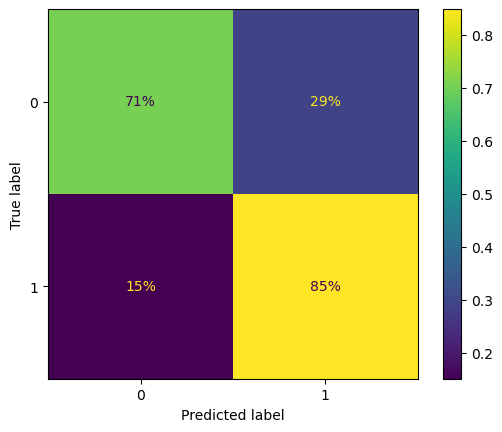

In [13]:
ConfusionMatrixDisplay.from_predictions(y_test, predictions, normalize='true', values_format='.0%')
plt.show()

In [14]:
print(f'Recall: {recall_score(y_test, predictions)}')
print(f'Precision: {precision_score(y_test, predictions)}')

Recall: 0.8484848484848485
Precision: 0.5107296137339056


In [15]:
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(len(feature_names)), importances[indices], align="center")
    plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
    plt.xlim([-1, len(feature_names)])
    plt.show()

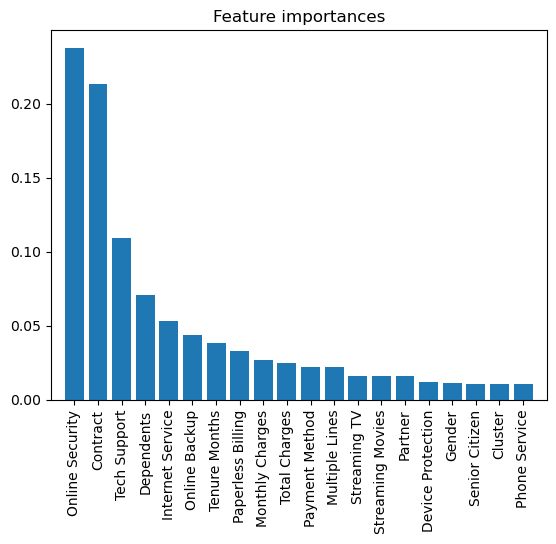

In [16]:
plot_feature_importance(xgb_model, X_train.columns)

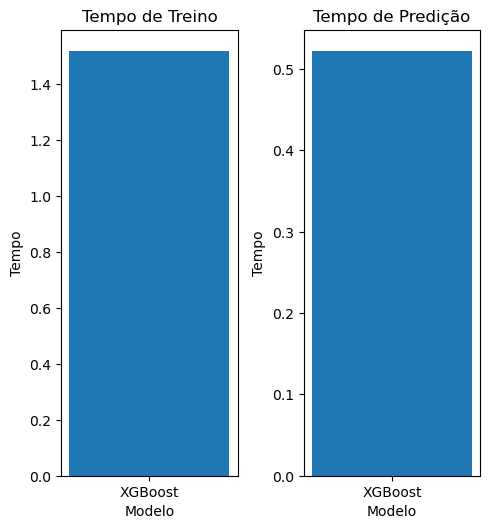

In [17]:
plt.figure(figsize=(5, 10))

plt.subplot(2, 2, 1)
plt.bar('XGBoost', train_time)
plt.title('Tempo de Treino')
plt.ylabel('Tempo')
plt.xlabel('Modelo')

plt.subplot(2, 2, 2)
plt.bar('XGBoost', predict_time)
plt.title('Tempo de Predição')
plt.ylabel('Tempo')
plt.xlabel('Modelo')

plt.tight_layout()
plt.show()